In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from IPython.display import display
import pdb
from multiprocessing import Pool

<IPython.core.display.Javascript object>


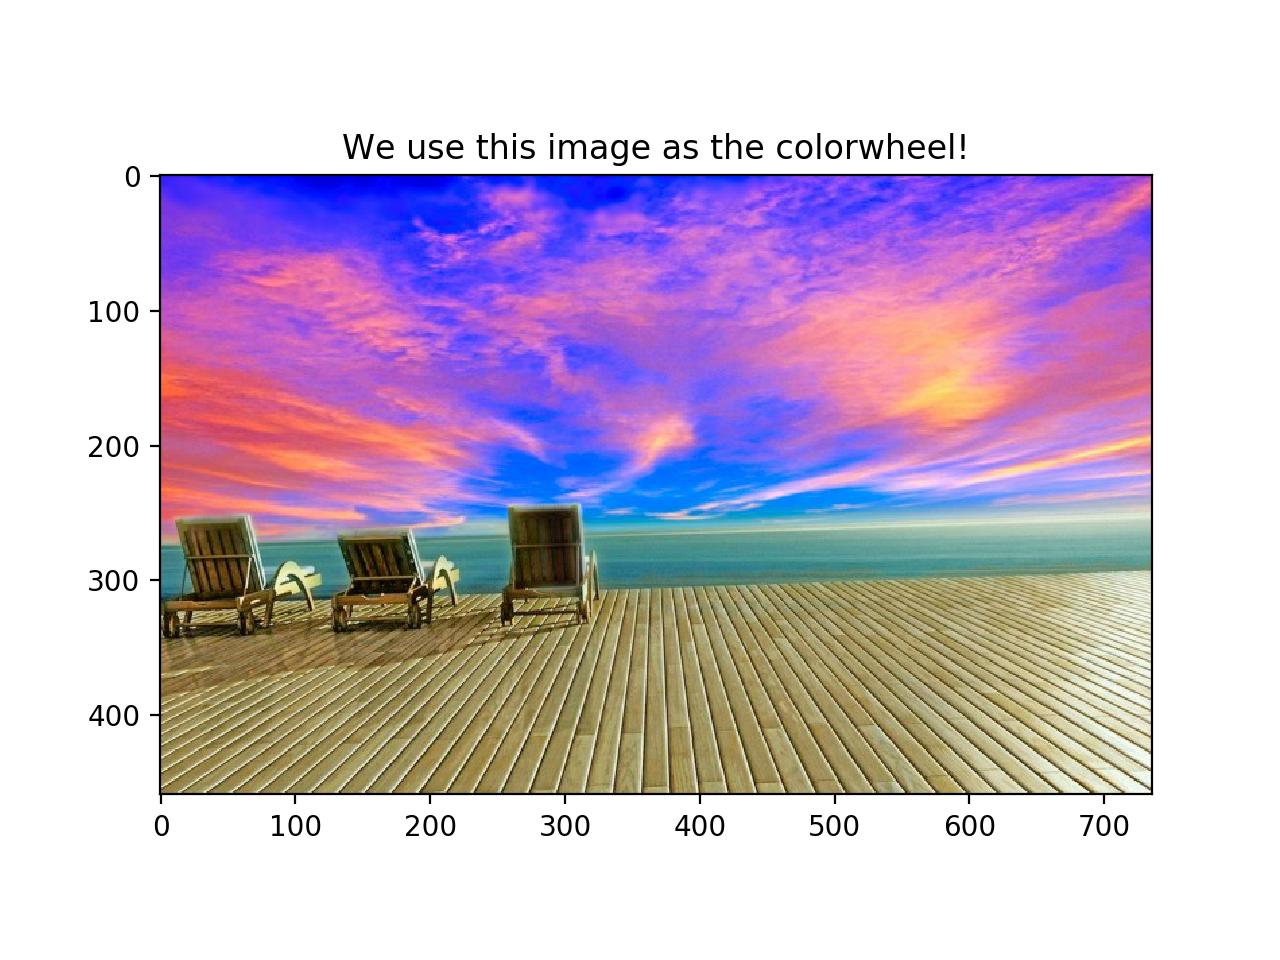

Image shape: (736, 459)


In [312]:
picNum = 1

im = Image.open("/Users/marke/Desktop/pic%s.jpg" % str(picNum))
colorWheel = np.array(im)
plt.figure()
plt.imshow(colorWheel)
plt.title("We use this image as the colorwheel!")
print "Image shape: " + str(im.size)

In [254]:
# GRAPHICS FUNCTIONS

def getRGB(z,minx,maxx,miny,maxy, imArray):
    dimx,dimy,_ = imArray.shape
    x = z.real
    y = z.imag
    xCoor = int(np.round(((x - minx)/float(maxx - minx)) * (dimx-1)))
    # if maxy = miny and you get an error, this is a degeneracy. use complex coefficients in nmDict !!!!
    yCoor = int(np.round(((y - miny)/float(maxy - miny)) * (dimy-1)))
        
    value = imArray[xCoor, yCoor, :]
    return value

def colorwheelApply(gridApply, imArray):
    allx = [z.real for z in gridApply.values()]
    ally = [z.imag for z in gridApply.values()]
    minx = min(allx)
    maxx = max(allx)
    miny = min(ally)
    maxy = max(ally)
    
    fundamentalDict = {}
    for key,value in gridApply.items():
        fundamentalDict[key] = getRGB(value,minx,maxx,miny,maxy, imArray)
    return fundamentalDict

    
def checkSymmetrySimple(gridApply):
    
    fundamentalDict = {}
    for key,value in gridApply.items():
         fundamentalDict[key] = np.array(((value.real * 1024) % 256 ,0, (value.imag * 1024) % 256), dtype='uint8')
        
    return fundamentalDict


def fundamentalColorGet(thisTuple):
    
    x,y = thisTuple[0]
    fundamentalDict = thisTuple[1]
    numStep = thisTuple[2]
    i,j = thisTuple[3]
    
    # convert x,y to lattice basis
    
    xPrime, yPrime = np.dot(d,[x,y])
    xIndex = int((xPrime % 1) * (numStep-1))
    yIndex = int((yPrime % 1) * (numStep-1))
    
    value = fundamentalDict[(xIndex,yIndex)]
    
    return ((i,j), value)
    

def tileFundamental(fundamentalDict, numStep, xmin, xmax, ymin, ymax, resx, resy):

    if resy == None:
        resy = int((resx * (ymax-ymin))/float(xmax - xmin))
        
    xv = np.linspace(xmin, xmax, resx)
    yv = np.linspace(ymin, ymax, resy)
    
    grid = [((x,y), fundamentalDict, numStep, (i,j)) for i,x in enumerate(xv) for j,y in enumerate(yv)]
    coordinateDict = dict([fundamentalColorGet(i) for i in grid])
    
    imOut = np.zeros((resy, resx, 3), dtype='uint8')
    for key,value in coordinateDict.items():
        i,j = key
        imOut[resy - j - 1, i, :] = value
        
    return imOut


def latticeEval(thisTuple):
    i,x,j,y = thisTuple
    
    z = (x * lattice_vector_1) + (y * lattice_vector_2)
    
    return ((i,j), myF(nmDict)((z.real, z.imag)))


def fundamentalCellDisplay(fundamentalDict, resx, resy):

    extremePoints = [0., lattice_vector_1, lattice_vector_2, lattice_vector_1 + lattice_vector_2]
    minx = min([i.real for i in extremePoints])
    maxx = max([i.real for i in extremePoints])
    miny = min([i.imag for i in extremePoints])
    maxy = max([i.imag for i in extremePoints])
    
    gap = max([maxy - miny, maxx - minx])
    maxx = minx + gap
    maxy = miny + gap
    
    imOut = np.zeros((resy, resx, 3), dtype='uint8')
    for key,value in fundamentalDict.items():
        z = ((lattice_vector_1 * key[0]) + (lattice_vector_2 * key[1])) / numStep
        x = z.real
        y = z.imag
        
        i = int(((x - minx)/(maxx-minx)) * (resx-1))
        j = int(((y - miny)/(maxy-miny)) * (resy-1))
        imOut[resy - j - 1,i,:] = value
     
    display(Image.fromarray(imOut))



In [244]:
# SYMMETRY FUNCTIONS

# GENERAL LATTICE
def E_general(nmPair,x,y):
    n,m = nmPair
    a = lattice_vector_2.real
    b = lattice_vector_2.imag
    X = x - ((a * y)/b)
    Y = y/b
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def f_general(nmDict):
    g = lambda xyPair : np.sum([value * E_general(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g


# RHOMBIC LATTICE
def E_rhombic(nmPair,x,y):
    n,m = nmPair
    X = x + (y/(2.*b))
    Y = x - (y/(2.*b))
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def f_rhombic(nmDict):
    g = lambda xyPair : np.sum([value * E_rhombic(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g


# RECTANGULAR LATTICE
def E_rectangular(nmPair,x,y):
    n,m = nmPair
    X = x 
    Y = y/L
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def f_rectagular(nmDict):
    g = lambda xyPair : np.sum([value * E_rectangular(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g


# SQUARE LATTICE
def E_square(nmPair,x,y):
    n,m = nmPair
    X = x 
    Y = y
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def S(nmPair0,x,y):
    n,m = nmPair0
    nmPair1 = (m,-n)
    nmPair2 = (-n,-m)
    nmPair3 = (-m,n)
    value = (E_square(nmPair0,x,y) + E_square(nmPair1,x,y) + E_square(nmPair2,x,y) + E_square(nmPair3,x,y))/4.
    return value

def f_square(nmDict):
    g = lambda xyPair : np.sum([value * S(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g

# HEXAGONAL LATTICE
def E_hex(nmPair,x,y):
    n,m = nmPair
    X = x + (y/np.sqrt(3))
    Y = (2 * y)/np.sqrt(3)
    value = np.exp(2 * np.pi * 1j * ((n * X) + (m * Y)))
    return value

def W(nmPair0,x,y):
    n,m = nmPair0
    nmPair1 = (m, -n - m)
    nmPair2 = (-n - m, n)
    value = (E_hex(nmPair0,x,y) + E_hex(nmPair1,x,y) + E_hex(nmPair2,x,y))/3.
    return value

def f_hex(nmDict):
    g = lambda xyPair : np.sum([value * W(key,xyPair[0],xyPair[1]) for key,value in nmDict.items()])
    return g


In [301]:
flag = 'hexagonal'

if flag == 'general':
    myF = f_general
    lattice_vector_1 = 1.
    lattice_vector_2 = 1. + 1j
    nmDict = {(1,0):1, (0,-1):1, (1,5):.5, (-5,-1):.5, (-2,4):.1*1j, (-4,2):.1*1j}
    
elif flag == 'rhombic':
    myF = f_rhombic
    b = 1.
    lattice_vector_1 = .5 + (b*1j)
    lattice_vector_2 = .5 - (b*1j)
    nmDict = {(1,0):1j, (0,1):1j}
    
elif flag == 'rectangular':
    myF = f_rectagular
    L = 2.
    lattice_vector_1 = 1.
    lattice_vector_2 = L * 1j
    nmDict = {(1,2):1j, (1,-2):1j}
    
elif flag == 'square':
    myF = f_square
    lattice_vector_1 = 1.
    lattice_vector_2 = 1j
    nmDict = {(1,0):1, (0,-1):1, (1,5):.5, (-5,-1):.5, (-2,4):.1*1j, (-4,2):.1*1j} 

elif flag == 'hexagonal':
    myF = f_hex
    lattice_vector_1 = 1.
    lattice_vector_2 = (-1 + (1j * np.sqrt(3)))/2.
    #nmDict = {(1,0):1, (0,-1):1, (1,5):.5, (-5,-1):.5, (-2,4):.1*1j, (-4,2):.1*1j} 
    nmDict = {(1,0):1j, (0,-1):5j, (-1,1):1j} 
    
else:
    raise Exception('bad type...')

# compute matrix "d" used for tiling a region by the fundamental cell
c = np.array([[lattice_vector_1.real, lattice_vector_2.real],[lattice_vector_1.imag,lattice_vector_2.imag]])
d = np.linalg.inv(c)

In [302]:
numStep = 1000

numCPU = 4
    
v = np.linspace(0,1,numStep)

if numStep <=200 or numCPU==1:
    gridApply = dict([latticeEval((i,x,j,y)) for i,x in enumerate(v) for j,y in enumerate(v)])
else:
    pool = Pool(numCPU)
    print "computing..."
    grid = [(i,x,j,y) for i,x in enumerate(v) for j,y in enumerate(v)]
    gridApply = dict(pool.map(latticeEval,grid))
    pool.close()
    print "done grid computing..."
    
fundamentalColorDict = colorwheelApply(gridApply, colorWheel)

computing...
done grid computing...


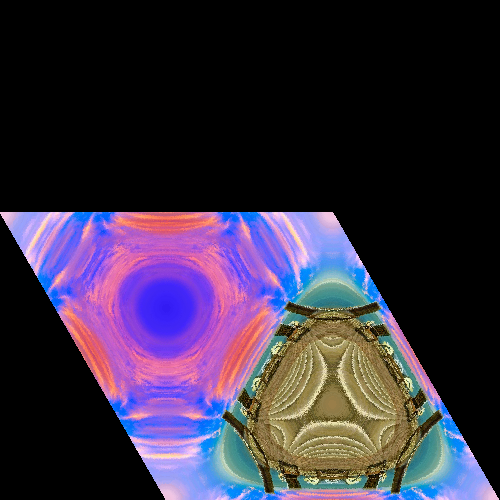

In [303]:
fundamentalCellDisplay(fundamentalColorDict, 500,500)

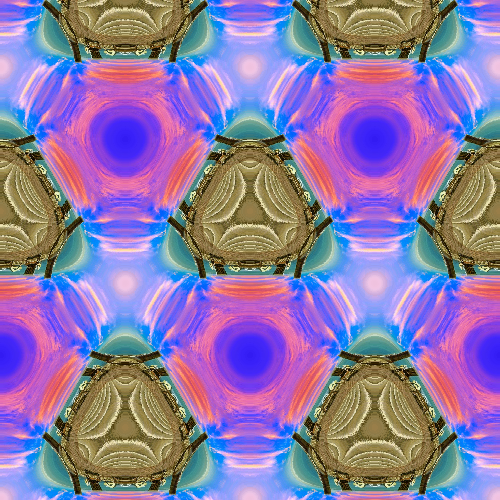

In [304]:
imOut = tileFundamental(fundamentalColorDict, numStep, xmin=0, xmax=2, ymin=0, ymax=2, 
                        resx=500, resy=None)
display(Image.fromarray(imOut))

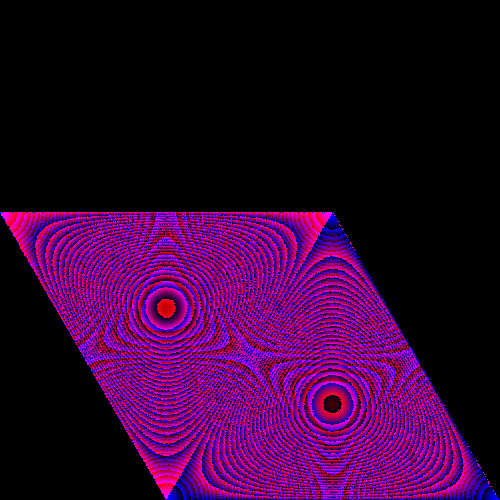

In [305]:
fundamentalSimpleSymDict = checkSymmetrySimple(gridApply)
fundamentalCellDisplay(fundamentalSimpleSymDict, 500,500)

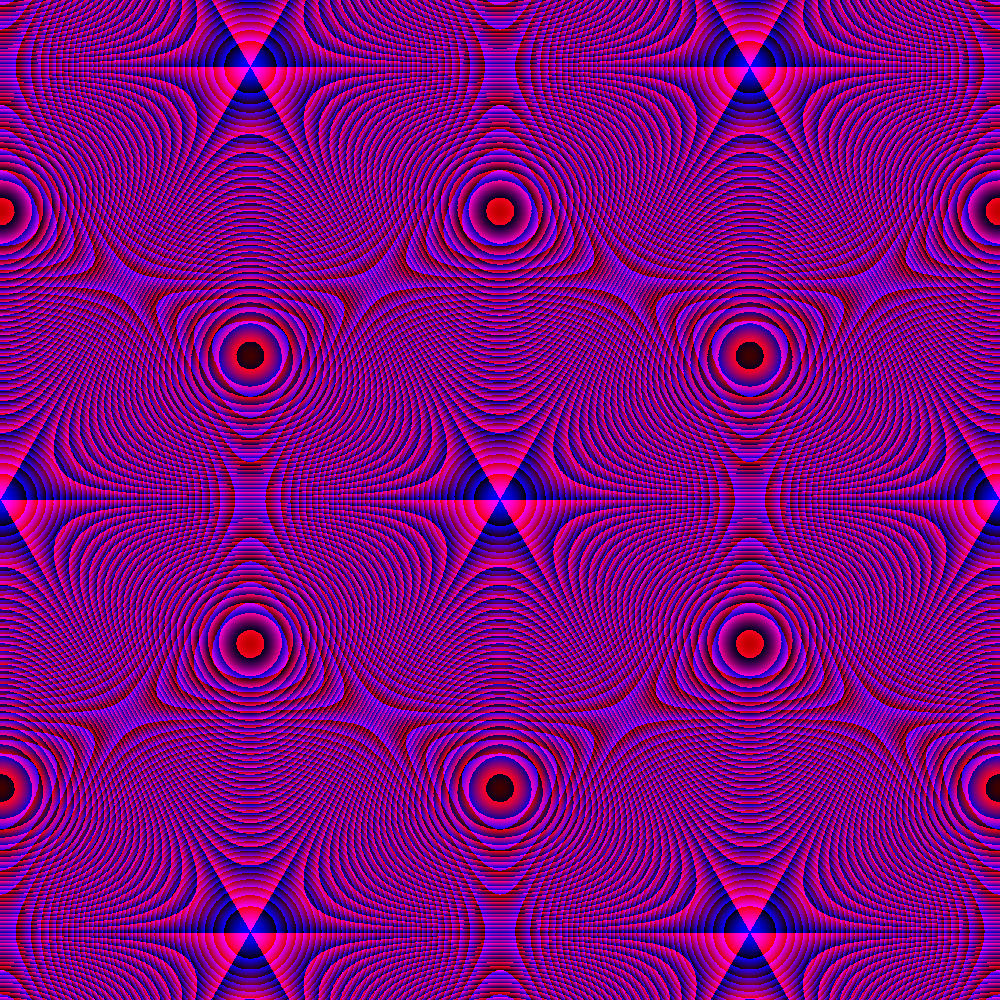

In [306]:
imOut1 = tileFundamental(fundamentalSimpleSymDict, numStep, xmin=-1, xmax=1, ymin=-1, ymax=1, resx=1000, resy=None)
display(Image.fromarray(imOut1))